# Variational Autoencoder: LeNet-300-100 _fully-connected_ layers with PyTorch and MNIST

In [ ]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER = PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 0

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import plotly, pickle
import plotly.express as px
import seaborn as sns
import numpy as np

/home/arjunm/anaconda3/envs/torch-cpu/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(f"torch version: {torch.__version__}")

torch version: 1.12.1


In [3]:
# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

Number of GPU(s) available = 0
PyTorch does not have access to GPU


In [4]:
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

Available device is cpu


In [5]:
# Hyper-parameters-
num_epochs = 80
batch_size = 256
learning_rate = 0.001

### MNIST data pre-processing:

#### Compute mean and standard deviation for different datasets

```
import argparse
import os
import numpy as np
import torchvision
import torchvision.transforms as transforms

dataset_names = ('cifar10','cifar100','mnist')

parser = argparse.ArgumentParser(description='PyTorchLab')
parser.add_argument('-d', '--dataset', metavar='DATA', default='cifar10', choices=dataset_names,
                    help='dataset to be used: ' + ' | '.join(dataset_names) + ' (default: cifar10)')

args = parser.parse_args()

data_dir = os.path.join('.', args.dataset)

print(args.dataset)

if args.dataset == "cifar10":
    train_transform = transforms.Compose([transforms.ToTensor()])
    train_set = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=train_transform)
    #print(vars(train_set))
    print(train_set.train_data.shape)
    print(train_set.train_data.mean(axis=(0,1,2))/255)
    print(train_set.train_data.std(axis=(0,1,2))/255)

elif args.dataset == "cifar100":
    train_transform = transforms.Compose([transforms.ToTensor()])
    train_set = torchvision.datasets.CIFAR100(root=data_dir, train=True, download=True, transform=train_transform)
    #print(vars(train_set))
    print(train_set.train_data.shape)
    print(np.mean(train_set.train_data, axis=(0,1,2))/255)
    print(np.std(train_set.train_data, axis=(0,1,2))/255)

elif args.dataset == "mnist":
    train_transform = transforms.Compose([transforms.ToTensor()])
    train_set = torchvision.datasets.MNIST(root=data_dir, train=True, download=True, transform=train_transform)
    #print(vars(train_set))
    print(list(train_set.train_data.size()))
    print(train_set.train_data.float().mean()/255)
    print(train_set.train_data.float().std()/255)
```

[Reference](https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457/11)

In [6]:
# Define transformations for MNIST dataset-
# MNIST dataset statistics-
mean = np.array([0.1307])
std_dev = np.array([0.3081])

transforms_apply = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean = mean, std = std_dev)
    ]
)

In [7]:
# Load MNIST dataset-
train_dataset = torchvision.datasets.MNIST(
        root = '/home/arjunm/Downloads/.data/', train = True,
        transform = transforms_apply, download = True
        )

test_dataset = torchvision.datasets.MNIST(
        root = "/home/arjunm/Downloads/.data/", train = False,
        transform = transforms_apply
        )

In [8]:
len(train_dataset.targets), len(train_dataset.data)

(60000, 60000)

In [9]:
len(test_dataset.targets), len(test_dataset.data)

(10000, 10000)

In [10]:
print(f"training dataset length/shape: {list(train_dataset.data.size())}")

training dataset length/shape: [60000, 28, 28]


In [11]:
print(f"mean = {train_dataset.data.float().mean() / 255:.4f}")

mean = 0.1307


In [12]:
print(f"std dev = {train_dataset.data.float().std() / 255:.4f}")

std dev = 0.3081


#### NOTE:

Since MNIST has only one channel, therefore, the mean and standard deviation is computed for one channel!

In [13]:
# Sanity check-
train_dataset.data.min(), train_dataset.data.max()

(tensor(0, dtype=torch.uint8), tensor(255, dtype=torch.uint8))

In [14]:
test_dataset.data.min(), test_dataset.data.max()

(tensor(0, dtype=torch.uint8), tensor(255, dtype=torch.uint8))

#### Scale pixel values in the range 0 to 1

To manually convert the pixel values in the range 0 to 1, divide the training and testing datasets by 255.0.

In [15]:
train = train_dataset.data.float() / 255.0
test = test_dataset.data.float() / 255.0

In [16]:
type(train), type(test)

(torch.Tensor, torch.Tensor)

In [17]:
train.shape, test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [18]:
# Reshape to include gray-scale channel-
# train = train.reshape(60000, 1, 28, 28)
# test = test.reshape(10000, 1, 28, 28)

# Reshape the datasets into a flattened shape for LeNet300
# architecture-
train = train.view(-1, 28 * 28 * 1)
test = test.view(-1, 28 * 28 * 1)

In [19]:
# Sanity check-
train.shape, test.shape

(torch.Size([60000, 784]), torch.Size([10000, 784]))

In [20]:
# Sanity check- min and max pixel values are in the range 0 to 1-
train.data.min(), train.data.max()

(tensor(0.), tensor(1.))

In [21]:
test.data.min(), test.data.max()

(tensor(0.), tensor(1.))

In [22]:
del train_dataset, test_dataset

In [23]:
print(f"batch size to be used = {batch_size}")

batch size to be used = 256


In [24]:
# Create training and testing dataloaders-
train_loader = torch.utils.data.DataLoader(
        dataset = train, batch_size = batch_size,
        shuffle = True
        )

test_loader = torch.utils.data.DataLoader(
        dataset = test, batch_size = batch_size,
        shuffle = False
        )

In [25]:
print(f"Sizes of train_dataset: {len(train)} and test_dataet: {len(test)}")
print(f"Sizes of train_loader: {len(train_loader)} and test_loader: {len(test_loader)}")

Sizes of train_dataset: 60000 and test_dataet: 10000
Sizes of train_loader: 235 and test_loader: 40


In [26]:
print(f"len(train_loader) = {len(train_loader)} & len(test_loader) = {len(test_loader)}")

len(train_loader) = 235 & len(test_loader) = 40


In [27]:
# Sanity check-
len(train) / batch_size, len(test) / batch_size

(234.375, 39.0625)

In [28]:
# Get some random batch of training images & labels-
# images, labels = next(iter(train_loader))
images = next(iter(train_loader))

# You get 64 images due to the specified batch size-
# print(f"images.shape: {images.shape} & labels.shape: {labels.shape}")
print(f"images.shape: {images.shape}")

images.shape: torch.Size([256, 784])


In [29]:
images.min(), images.max()

(tensor(0.), tensor(1.))

In [30]:
# De-normalize the batch of images-
images *= 255.0

In [31]:
images.min(), images.max()

(tensor(0.), tensor(255.))

In [32]:
# Reshape images for visualization-
images = images.view(-1, 1, 28, 28)

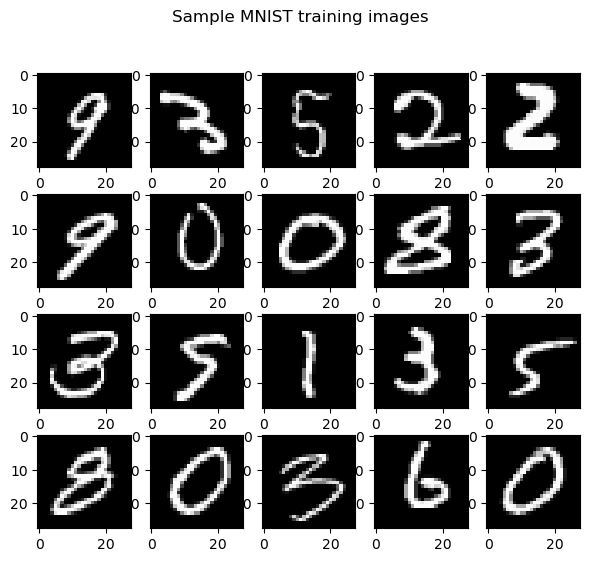

In [34]:
# Visualize 20 images from training set-
plt.figure(figsize = (7, 6))
for i in range(20):
    # 4 rows & 5 columns-
    plt.subplot(4, 5, i + 1)
    # plt.imshow(images[i], cmap = 'gray')
    # 0 to access first channel-
    plt.imshow(images[i][0], cmap = 'gray')
    
plt.suptitle("Sample MNIST training images")
plt.show()

In [35]:
del images

### Define Variational Autoencoder architecture using _dense_ layers

In [36]:
class LeNet300_Encoder(nn.Module):
    def __init__(self, latent_space):
        super(LeNet300_Encoder, self).__init__()
        self.latent_space = latent_space
        
        # Define layers-
        self.fc1 = nn.Linear(in_features = 28 * 28 * 1, out_features = 300)
        self.fc2 = nn.Linear(in_features = 300, out_features = 100)
        self.encoder_output = nn.Linear(in_features = 100, out_features = self.latent_space)
        
        self.weights_initialization()
    
    
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.encoder_output(x))
        return x
    
    
    def weights_initialization(self):
        '''
        When we define all the modules such as the layers in '__init__()'
        method above, these are all stored in 'self.modules()'.
        We go through each module one by one. This is the entire network,
        basically.
        '''
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = self.fc1(x)
        print(f"dense1 output shape: {x.shape}")
        x = self.fc2(x)
        print(f"dense2 output shape: {x.shape}")
        x = self.encoder_output(x)
        print(f"encoder output shape: {x.shape}")
        del x
        return None
    
    

In [37]:
class LeNet300_Decoder(nn.Module):
    def __init__(self, latent_space):
        super(LeNet300_Decoder, self).__init__()
        self.latent_space = latent_space
        
        # Define layers-
        self.fc1 = nn.Linear(in_features = self.latent_space, out_features = 50)
        self.fc2 = nn.Linear(in_features = 50, out_features = 100)
        self.fc3 = nn.Linear(in_features = 100, out_features = 300)
        self.decoder_output = nn.Linear(in_features = 300, out_features = 28 * 28 * 1)
    
    
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        x = self.decoder_output(x)
        return x
    
    
    def weights_initialization(self):
        '''
        When we define all the modules such as the layers in '__init__()'
        method above, these are all stored in 'self.modules()'.
        We go through each module one by one. This is the entire network,
        basically.
        '''
        for m in self.modules():
            if isinstance(m, nn.Linear):
                # nn.init.kaiming_normal_(m.weight)
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = self.fc1(x)
        print(f"dense1 output shape: {x.shape}")
        x = self.fc2(x)
        print(f"dense2 output shape: {x.shape}")
        x = self.fc3(x)
        print(f"dense3 output shape: {x.shape}")
        x = self.decoder_output(x)
        print(f"decoder output shape: {x.shape}")
        del x
        return None
    

In [38]:
class VAE_Dense(nn.Module):
    def __init__(self, latent_space = 5):
        super(VAE_Dense, self).__init__()
        
        self.latent_space = latent_space
        
        # Encoder-
        self.encoder = LeNet300_Encoder(latent_space = self.latent_space).to(device)
        
        # Two additional layers 'mu' & 'log_var' vectors to convert the bottleneck into
        # μ and σ vectors-
        self.mu = nn.Linear(
            in_features = self.latent_space, out_features = self.latent_space,
            bias = True
        )
        self.log_var = nn.Linear(
            in_features = self.latent_space, out_features = self.latent_space,
            bias = True
        )
        
        # Decoder-
        self.decoder = LeNet300_Decoder(latent_space = self.latent_space).to(device)
        
        
    def reparameterize(self, mu, log_var):
        '''
        Input arguments:
        1. mu - mean coming from the encoder's latent space
        2. log_var - log variance coming from the encoder's latent space
        
        The log-var trick allows us to have both positive and negative values instead
        of only having positive values if standard deviation was used. Having both
        positive & negative values is good for the neural network training process.
        '''
        # Compute standard deviation using 'log_var'-
        std = torch.exp(0.5 * log_var)
        
        # 'eps' is sampled from a standard normal distribution
        # to add stochasticity to the sampling process-
        eps = torch.randn_like(std)
        
        # Reparameterization trick - sample as if it's from the input
        # space-
        z = mu + (std * eps)
        
        return z
    
    
    def forward(self, x):
        # Encode input data using encoder-
        x = self.encoder(x)
        # NOTE: The line of code above does NOT give us the latent vector!
        
        mu = self.mu(x)
        log_var = self.log_var(x)
        
        # Obtain the latent vector using reparameterization-
        z = self.reparameterize(mu, log_var)
        # latent vector 'z' is obtained through reparameterization trick using mu and log_var
        
        # Decode latent vector using decoder-
        recon_data = torch.sigmoid(self.decoder(z))
        # recon_data = torch.tanh(self.decoder(z))
        
        return recon_data, mu, log_var
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = self.encoder(x)
        print(f"Encoder output shape: {x.shape}")
        mu = self.mu(x)
        log_var = self.log_var(x)
        z = self.reparameterize(mu, log_var)
        print(f"mu.shape: {mu.shape}, log_var.shape: {log_var.shape}"
              f" & z.shape: {z.shape}")
        x = self.decoder(z)
        print(f"Decoder output shape: {x.shape}")
        del x, mu, log_var, z
        return None
    
    

In [39]:
# Initialize a VAE object-
model = VAE_Dense(latent_space = 3).to(device)

In [40]:
# Count number of layer-wise parameters and total parameters-
tot_params = 0
for param in model.parameters():
    # print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
    tot_params += param.nelement()

In [41]:
print(f"Total number of parameters in VAE Conv model = {tot_params}")

Total number of parameters in VAE Conv model = 537511


In [ ]:
# Save trained VAE model's weights-
# torch.save(model.state_dict(), 'VAE_LeNet300_MNIST_Random_Weights.pth')

In [ ]:
# Load trained weights from before-
# loaded_model = VAE_Dense(latent_space = 3).to(device)
# loaded_model.load_state_dict(torch.load(VAE_LeNet300_MNIST_Random_Weights.pth', map_location = torch.device('cpu')))

In [42]:
# Sanity check-
images = next(iter(train_loader))

In [43]:
images.shape

torch.Size([256, 784])

In [44]:
images.min(), images.max()

(tensor(0.), tensor(1.))

In [45]:
# Sanity check-
recon_images, mu, log_var = model(images)

In [46]:
recon_images.shape, mu.shape, log_var.shape

(torch.Size([256, 784]), torch.Size([256, 3]), torch.Size([256, 3]))

In [47]:
recon_images.min().detach().cpu().numpy(), recon_images.max().detach().cpu().numpy()

(array(0.3959343, dtype=float32), array(0.5869703, dtype=float32))

In [48]:
del images, recon_images, mu, log_var

In [49]:
print(f"Adam optimizer with learning rate = {learning_rate} will be used")

Adam optimizer with learning rate = 0.001 will be used


In [50]:
# Define gradient descent optimizer-
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 5e-4)

In [51]:
def total_loss(data, data_recon, mu, log_var, beta = 1):
    '''
    Function to compute loss = reconstruction loss * reconstruction_term_weight + KL-Divergence loss.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    
    Inputs:
    1. mu: mean from the latent vector
    2. logvar: log variance from the latent vector
    3. alpha (int): Hyperparameter to control the importance of reconstruction
    loss vs KL-Divergence Loss - reconstruction term weight
    4. data: training data
    5. data_recon: VAE's reconstructed data
    '''
    
    # Compute KL-Divergence loss:
    
    # Sum over latent dimensions-
    kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - torch.exp(log_var), axis = 1)
    # kl_div = -0.5 * torch.sum(1 + log_var - (mu **2) - torch.exp(log_var), axis = 1)
    
    '''
    Omitting 'axis' will give bad results as it will sum over everything!
    First, sum over the latent dimensions and then average over the batches.
    '''
    
    # kl_div.shape
    # torch.Size([64])
    
    batchsize = kl_div.size(0)

    # Compute average KL-divergence over batch size-
    kl_div = kl_div.mean()
    
    
    # Compute Reconstruction loss:
    
    reconstruction_loss_fn = F.mse_loss
    recon_loss = reconstruction_loss_fn(data_recon, data, reduction = 'none')
    
    # recon_loss.shape
    # torch.Size([32, 1, 28, 28])
    
    # Sum over all pixels-
    # Reshape recon_loss so that it is the batchsize and a vector. So, instead
    # of having a tensor, it is now a matrix (table). Then, sum over the pixels.
    # This is equivalent to summing over the latent dimensions for kl_div above.
    # We are summing first the squared error over the pixels and then average over
    # the batch dimensions below-
    recon_loss = recon_loss.view(batchsize, -1).sum(axis = 1)
    
    # recon_loss.shape
    # torch.Size([64, 784])
    
    # Average over mini-batch dimension-
    recon_loss = recon_loss.mean()
    
    final_loss = recon_loss + (beta * kl_div)
    
    return final_loss, recon_loss, kl_div


In [52]:
def train_one_epoch(model, dataloader, train_dataset, beta):
    
    # Place model to device-
    model.to(device)
    
    # Enable training mode-
    model.train()
    
    # Initialize variables to keep track of 3 losses-
    running_final_loss = 0.0
    running_recon_loss = 0.0
    running_kl_loss = 0.0
    
    
    for i, data in tqdm(
        enumerate(dataloader),
        total = int(len(train_dataset) / dataloader.batch_size)
        # total = int(len(train) / dataloader.batch_size)
        ):
      
        # Ignore labels-
        # data, _ = data

        # Push data points to 'device'-
        data = data.to(device)
        
        # Flatten input data to feed into a dense layer-
        # data = data.view(data.size(0), -1)
        
        # Empty accumulated gradients-
        optimizer.zero_grad()
        
        # Perform forward propagation-
        recon_data, mu, logvar = model(data)
        
        final_loss, recon_loss, kl_div_loss = total_loss(
            data = data, data_recon = recon_data,
            mu = mu, log_var = logvar,
            beta = beta
        )
        
        # Update losses-
        running_final_loss += final_loss.item()
        running_kl_loss += kl_div_loss.cpu().detach().numpy()
        running_recon_loss += recon_loss.cpu().detach().numpy()
        
        # Compute gradients wrt total loss-
        final_loss.backward()
        
        # Perform gradient descent-
        optimizer.step()
    
    # Compute losses as float values-
    train_loss = running_final_loss / len(dataloader.dataset)
    kl_loss = running_kl_loss / len(dataloader.dataset)
    recon_loss = running_recon_loss / len(dataloader.dataset)
    
    return train_loss, kl_loss, recon_loss


In [53]:
def validate_one_epoch(model, dataloader, test_dataset, beta):
    
    # Place model to device-
    model.to(device)
    
    # Enable evaluation mode-
    model.eval()
    
    running_final_loss = 0.0
    running_recon_loss = 0.0
    running_kl_loss = 0.0
    
    with torch.no_grad():
        for i, data in tqdm(
            enumerate(dataloader),
            total = int(len(test_dataset) / dataloader.batch_size)):
            # total = int(len(test) / test_loader.batch_size)):
          
            # Ignore labels-
            # data, _ = data

            # Push data points to 'device'-
            data = data.to(device)
            
            # Flatten data to feed into a dense layer-
            # data = data.view(data.size(0), -1)
            
            # Forward propagation-
            recon_data, mu, logvar = model(data)
            
            final_loss, recon_loss, kl_div_loss = total_loss(
                data = data, data_recon = recon_data,
                mu = mu, log_var = logvar,
                beta = beta
            )
        
            # Update losses-
            running_final_loss += final_loss.item()
            running_kl_loss += kl_div_loss.cpu().detach().numpy()
            running_recon_loss += recon_loss.cpu().detach().numpy()
            
                
    val_loss = running_final_loss / len(dataloader.dataset)
    val_kl_loss = running_kl_loss / len(dataloader.dataset)
    val_recon_loss = running_recon_loss / len(dataloader.dataset)
    
    return val_loss, val_kl_loss, val_recon_loss

    

### Train VAE model 

In [54]:
# Python dict to contain training metrics-
train_history = {}

In [55]:
# Initialize parameter for saving 'best' parameters-
best_val_loss = 10000

In [57]:
for epoch in range(1, num_epochs + 1):
    
    # Train model for 1 epoch-
    train_loss, kl_train_loss, recon_train_loss = train_one_epoch(
        model = model, dataloader = train_loader,
        train_dataset = train, beta = 1
    )
    
    # Get validation after 1 epoch-
    val_loss, val_kl_loss, val_recon_loss = validate_one_epoch(
        model = model, dataloader = test_loader,
        test_dataset = test, beta = 1
    )
    
    # Store model performance metrics in Python3 dict-
    train_history[epoch] = {
        'train_loss': train_loss,
        'train_recon_loss': kl_train_loss,
        'train_kl_loss': kl_train_loss,
        'val_loss': val_loss,
        'val_recon_loss': val_recon_loss,
        'val_kl_loss': val_kl_loss
    }
    
    print(f"Epoch = {epoch}; train loss = {train_loss:.4f}",
          f", kl-loss = {kl_train_loss:.4f}, recon loss = {recon_train_loss:.4f}",
          f", val loss = {val_loss:.4f}, val kl-loss = {val_kl_loss:.4f}",
          f" & val recon loss = {val_recon_loss:.4f}"
         )
    
    
    # Code for manual Early Stopping:
    if (val_loss < best_val_loss):

        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = val_loss
        
        print(f"Saving model with lowest val_loss = {val_loss:.4f}\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model.state_dict(), "VAE_LeNet300_MNIST_best_model.pth")
        
    

235it [00:01, 124.86it/s]                                                       
40it [00:00, 454.22it/s]                                                        


Epoch = 1; train loss = 0.2215 , kl-loss = 0.0060, recon loss = 0.2155 , val loss = 0.1930, val kl-loss = 0.0079  & val recon loss = 0.1851
Saving model with lowest val_loss = 0.1930



235it [00:01, 130.38it/s]                                                       
40it [00:00, 450.60it/s]                                                        


Epoch = 2; train loss = 0.1775 , kl-loss = 0.0122, recon loss = 0.1652 , val loss = 0.1701, val kl-loss = 0.0166  & val recon loss = 0.1535
Saving model with lowest val_loss = 0.1701



235it [00:01, 131.48it/s]                                                       
40it [00:00, 301.89it/s]                                                        


Epoch = 3; train loss = 0.1609 , kl-loss = 0.0181, recon loss = 0.1428 , val loss = 0.1603, val kl-loss = 0.0201  & val recon loss = 0.1402
Saving model with lowest val_loss = 0.1603



235it [00:01, 128.55it/s]                                                       
40it [00:00, 449.91it/s]                                                        


Epoch = 4; train loss = 0.1537 , kl-loss = 0.0199, recon loss = 0.1338 , val loss = 0.1548, val kl-loss = 0.0216  & val recon loss = 0.1332
Saving model with lowest val_loss = 0.1548



235it [00:01, 132.66it/s]                                                       
40it [00:00, 450.60it/s]                                                        


Epoch = 5; train loss = 0.1498 , kl-loss = 0.0209, recon loss = 0.1288 , val loss = 0.1516, val kl-loss = 0.0212  & val recon loss = 0.1304
Saving model with lowest val_loss = 0.1516



235it [00:01, 136.73it/s]                                                       
40it [00:00, 437.30it/s]                                                        


Epoch = 6; train loss = 0.1467 , kl-loss = 0.0215, recon loss = 0.1251 , val loss = 0.1490, val kl-loss = 0.0221  & val recon loss = 0.1269
Saving model with lowest val_loss = 0.1490



235it [00:01, 123.47it/s]                                                       
40it [00:00, 438.52it/s]                                                        


Epoch = 7; train loss = 0.1445 , kl-loss = 0.0221, recon loss = 0.1224 , val loss = 0.1470, val kl-loss = 0.0230  & val recon loss = 0.1241
Saving model with lowest val_loss = 0.1470



235it [00:01, 125.31it/s]                                                       
40it [00:00, 430.53it/s]                                                        


Epoch = 8; train loss = 0.1427 , kl-loss = 0.0224, recon loss = 0.1203 , val loss = 0.1457, val kl-loss = 0.0226  & val recon loss = 0.1231
Saving model with lowest val_loss = 0.1457



235it [00:01, 133.80it/s]                                                       
40it [00:00, 417.39it/s]                                                        


Epoch = 9; train loss = 0.1411 , kl-loss = 0.0228, recon loss = 0.1184 , val loss = 0.1440, val kl-loss = 0.0235  & val recon loss = 0.1205
Saving model with lowest val_loss = 0.1440



235it [00:01, 128.70it/s]                                                       
40it [00:00, 443.66it/s]                                                        


Epoch = 10; train loss = 0.1398 , kl-loss = 0.0230, recon loss = 0.1167 , val loss = 0.1428, val kl-loss = 0.0239  & val recon loss = 0.1189
Saving model with lowest val_loss = 0.1428



235it [00:01, 128.77it/s]                                                       
40it [00:00, 455.82it/s]                                                        


Epoch = 11; train loss = 0.1385 , kl-loss = 0.0232, recon loss = 0.1153 , val loss = 0.1417, val kl-loss = 0.0235  & val recon loss = 0.1182
Saving model with lowest val_loss = 0.1417



235it [00:01, 131.43it/s]                                                       
40it [00:00, 427.49it/s]                                                        


Epoch = 12; train loss = 0.1376 , kl-loss = 0.0235, recon loss = 0.1141 , val loss = 0.1409, val kl-loss = 0.0244  & val recon loss = 0.1165
Saving model with lowest val_loss = 0.1409



235it [00:01, 127.62it/s]                                                       
40it [00:00, 459.26it/s]                                                        


Epoch = 13; train loss = 0.1366 , kl-loss = 0.0236, recon loss = 0.1130 , val loss = 0.1398, val kl-loss = 0.0242  & val recon loss = 0.1157
Saving model with lowest val_loss = 0.1398



235it [00:01, 135.98it/s]                                                       
40it [00:00, 314.80it/s]                                                        


Epoch = 14; train loss = 0.1357 , kl-loss = 0.0238, recon loss = 0.1119 , val loss = 0.1390, val kl-loss = 0.0244  & val recon loss = 0.1146
Saving model with lowest val_loss = 0.1390



235it [00:01, 130.12it/s]                                                       
40it [00:00, 421.69it/s]                                                        


Epoch = 15; train loss = 0.1350 , kl-loss = 0.0239, recon loss = 0.1111 , val loss = 0.1383, val kl-loss = 0.0239  & val recon loss = 0.1144
Saving model with lowest val_loss = 0.1383



235it [00:01, 135.52it/s]                                                       
40it [00:00, 459.33it/s]                                                        


Epoch = 16; train loss = 0.1343 , kl-loss = 0.0241, recon loss = 0.1102 , val loss = 0.1380, val kl-loss = 0.0246  & val recon loss = 0.1134
Saving model with lowest val_loss = 0.1380



235it [00:01, 133.14it/s]                                                       
40it [00:00, 424.60it/s]                                                        


Epoch = 17; train loss = 0.1337 , kl-loss = 0.0242, recon loss = 0.1095 , val loss = 0.1376, val kl-loss = 0.0247  & val recon loss = 0.1129
Saving model with lowest val_loss = 0.1376



235it [00:01, 123.70it/s]                                                       
40it [00:00, 428.58it/s]                                                        


Epoch = 18; train loss = 0.1330 , kl-loss = 0.0244, recon loss = 0.1086 , val loss = 0.1367, val kl-loss = 0.0247  & val recon loss = 0.1120
Saving model with lowest val_loss = 0.1367



235it [00:01, 130.87it/s]                                                       
40it [00:00, 433.84it/s]                                                        


Epoch = 19; train loss = 0.1323 , kl-loss = 0.0244, recon loss = 0.1078 , val loss = 0.1359, val kl-loss = 0.0244  & val recon loss = 0.1115
Saving model with lowest val_loss = 0.1359



235it [00:01, 126.17it/s]                                                       
40it [00:00, 363.34it/s]                                                        


Epoch = 20; train loss = 0.1319 , kl-loss = 0.0245, recon loss = 0.1074 , val loss = 0.1366, val kl-loss = 0.0250  & val recon loss = 0.1116


235it [00:01, 129.05it/s]                                                       
40it [00:00, 280.79it/s]                                                        


Epoch = 21; train loss = 0.1314 , kl-loss = 0.0247, recon loss = 0.1067 , val loss = 0.1353, val kl-loss = 0.0255  & val recon loss = 0.1099
Saving model with lowest val_loss = 0.1353



235it [00:01, 126.69it/s]                                                       
40it [00:00, 433.26it/s]                                                        


Epoch = 22; train loss = 0.1310 , kl-loss = 0.0248, recon loss = 0.1062 , val loss = 0.1349, val kl-loss = 0.0251  & val recon loss = 0.1098
Saving model with lowest val_loss = 0.1349



235it [00:01, 129.15it/s]                                                       
40it [00:00, 443.78it/s]                                                        


Epoch = 23; train loss = 0.1306 , kl-loss = 0.0249, recon loss = 0.1056 , val loss = 0.1344, val kl-loss = 0.0252  & val recon loss = 0.1092
Saving model with lowest val_loss = 0.1344



235it [00:01, 130.02it/s]                                                       
40it [00:00, 421.49it/s]                                                        


Epoch = 24; train loss = 0.1303 , kl-loss = 0.0251, recon loss = 0.1052 , val loss = 0.1343, val kl-loss = 0.0258  & val recon loss = 0.1085
Saving model with lowest val_loss = 0.1343



235it [00:01, 131.18it/s]                                                       
40it [00:00, 446.40it/s]                                                        


Epoch = 25; train loss = 0.1298 , kl-loss = 0.0251, recon loss = 0.1047 , val loss = 0.1344, val kl-loss = 0.0253  & val recon loss = 0.1091


235it [00:01, 135.71it/s]                                                       
40it [00:00, 437.52it/s]                                                        


Epoch = 26; train loss = 0.1296 , kl-loss = 0.0252, recon loss = 0.1044 , val loss = 0.1339, val kl-loss = 0.0258  & val recon loss = 0.1080
Saving model with lowest val_loss = 0.1339



235it [00:01, 134.62it/s]                                                       
40it [00:00, 436.69it/s]                                                        


Epoch = 27; train loss = 0.1292 , kl-loss = 0.0253, recon loss = 0.1039 , val loss = 0.1340, val kl-loss = 0.0254  & val recon loss = 0.1085


235it [00:01, 131.76it/s]                                                       
40it [00:00, 300.64it/s]                                                        


Epoch = 28; train loss = 0.1290 , kl-loss = 0.0254, recon loss = 0.1036 , val loss = 0.1339, val kl-loss = 0.0256  & val recon loss = 0.1084


235it [00:01, 123.26it/s]                                                       
40it [00:00, 433.27it/s]                                                        


Epoch = 29; train loss = 0.1287 , kl-loss = 0.0254, recon loss = 0.1032 , val loss = 0.1335, val kl-loss = 0.0256  & val recon loss = 0.1078
Saving model with lowest val_loss = 0.1335



235it [00:01, 129.07it/s]                                                       
40it [00:00, 275.44it/s]                                                        


Epoch = 30; train loss = 0.1283 , kl-loss = 0.0255, recon loss = 0.1028 , val loss = 0.1335, val kl-loss = 0.0260  & val recon loss = 0.1075


235it [00:01, 127.36it/s]                                                       
40it [00:00, 424.30it/s]                                                        


Epoch = 31; train loss = 0.1281 , kl-loss = 0.0256, recon loss = 0.1025 , val loss = 0.1330, val kl-loss = 0.0261  & val recon loss = 0.1069
Saving model with lowest val_loss = 0.1330



235it [00:01, 118.69it/s]                                                       
40it [00:00, 426.16it/s]                                                        


Epoch = 32; train loss = 0.1279 , kl-loss = 0.0257, recon loss = 0.1022 , val loss = 0.1326, val kl-loss = 0.0261  & val recon loss = 0.1066
Saving model with lowest val_loss = 0.1326



235it [00:01, 120.79it/s]                                                       
40it [00:00, 395.21it/s]                                                        


Epoch = 33; train loss = 0.1276 , kl-loss = 0.0257, recon loss = 0.1019 , val loss = 0.1330, val kl-loss = 0.0258  & val recon loss = 0.1072


235it [00:01, 123.49it/s]                                                       
40it [00:00, 299.14it/s]                                                        


Epoch = 34; train loss = 0.1274 , kl-loss = 0.0258, recon loss = 0.1016 , val loss = 0.1325, val kl-loss = 0.0265  & val recon loss = 0.1060
Saving model with lowest val_loss = 0.1325



235it [00:01, 124.85it/s]                                                       
40it [00:00, 420.62it/s]                                                        


Epoch = 35; train loss = 0.1272 , kl-loss = 0.0258, recon loss = 0.1014 , val loss = 0.1322, val kl-loss = 0.0262  & val recon loss = 0.1060
Saving model with lowest val_loss = 0.1322



235it [00:01, 131.84it/s]                                                       
40it [00:00, 328.50it/s]                                                        


Epoch = 36; train loss = 0.1270 , kl-loss = 0.0259, recon loss = 0.1011 , val loss = 0.1323, val kl-loss = 0.0265  & val recon loss = 0.1058


235it [00:01, 134.41it/s]                                                       
40it [00:00, 401.52it/s]                                                        


Epoch = 37; train loss = 0.1269 , kl-loss = 0.0259, recon loss = 0.1010 , val loss = 0.1327, val kl-loss = 0.0263  & val recon loss = 0.1064


235it [00:01, 135.39it/s]                                                       
40it [00:00, 435.20it/s]                                                        


Epoch = 38; train loss = 0.1267 , kl-loss = 0.0260, recon loss = 0.1007 , val loss = 0.1327, val kl-loss = 0.0262  & val recon loss = 0.1066


235it [00:01, 131.00it/s]                                                       
40it [00:00, 433.03it/s]                                                        


Epoch = 39; train loss = 0.1264 , kl-loss = 0.0260, recon loss = 0.1004 , val loss = 0.1320, val kl-loss = 0.0266  & val recon loss = 0.1053
Saving model with lowest val_loss = 0.1320



235it [00:01, 132.77it/s]                                                       
40it [00:00, 432.56it/s]                                                        


Epoch = 40; train loss = 0.1262 , kl-loss = 0.0261, recon loss = 0.1001 , val loss = 0.1320, val kl-loss = 0.0267  & val recon loss = 0.1053


235it [00:01, 130.87it/s]                                                       
40it [00:00, 430.56it/s]                                                        


Epoch = 41; train loss = 0.1261 , kl-loss = 0.0262, recon loss = 0.0999 , val loss = 0.1314, val kl-loss = 0.0265  & val recon loss = 0.1049
Saving model with lowest val_loss = 0.1314



235it [00:01, 131.77it/s]                                                       
40it [00:00, 342.06it/s]                                                        


Epoch = 42; train loss = 0.1259 , kl-loss = 0.0262, recon loss = 0.0997 , val loss = 0.1317, val kl-loss = 0.0267  & val recon loss = 0.1050


235it [00:01, 127.08it/s]                                                       
40it [00:00, 386.63it/s]                                                        


Epoch = 43; train loss = 0.1258 , kl-loss = 0.0263, recon loss = 0.0994 , val loss = 0.1312, val kl-loss = 0.0267  & val recon loss = 0.1044
Saving model with lowest val_loss = 0.1312



235it [00:01, 118.36it/s]                                                       
40it [00:00, 414.48it/s]                                                        


Epoch = 44; train loss = 0.1256 , kl-loss = 0.0263, recon loss = 0.0994 , val loss = 0.1310, val kl-loss = 0.0269  & val recon loss = 0.1040
Saving model with lowest val_loss = 0.1310



235it [00:01, 132.68it/s]                                                       
40it [00:00, 446.52it/s]                                                        


Epoch = 45; train loss = 0.1254 , kl-loss = 0.0263, recon loss = 0.0991 , val loss = 0.1313, val kl-loss = 0.0267  & val recon loss = 0.1047


235it [00:01, 134.38it/s]                                                       
40it [00:00, 430.10it/s]                                                        


Epoch = 46; train loss = 0.1253 , kl-loss = 0.0264, recon loss = 0.0989 , val loss = 0.1307, val kl-loss = 0.0266  & val recon loss = 0.1041
Saving model with lowest val_loss = 0.1307



235it [00:01, 128.15it/s]                                                       
40it [00:00, 410.39it/s]                                                        


Epoch = 47; train loss = 0.1252 , kl-loss = 0.0265, recon loss = 0.0987 , val loss = 0.1308, val kl-loss = 0.0267  & val recon loss = 0.1042


235it [00:01, 130.83it/s]                                                       
40it [00:00, 409.88it/s]                                                        


Epoch = 48; train loss = 0.1251 , kl-loss = 0.0265, recon loss = 0.0986 , val loss = 0.1314, val kl-loss = 0.0269  & val recon loss = 0.1045


235it [00:01, 130.73it/s]                                                       
40it [00:00, 403.55it/s]                                                        


Epoch = 49; train loss = 0.1250 , kl-loss = 0.0265, recon loss = 0.0984 , val loss = 0.1310, val kl-loss = 0.0268  & val recon loss = 0.1042


235it [00:01, 129.24it/s]                                                       
40it [00:00, 383.28it/s]                                                        


Epoch = 50; train loss = 0.1248 , kl-loss = 0.0266, recon loss = 0.0982 , val loss = 0.1311, val kl-loss = 0.0271  & val recon loss = 0.1040


235it [00:01, 125.88it/s]                                                       
40it [00:00, 430.11it/s]                                                        


Epoch = 51; train loss = 0.1248 , kl-loss = 0.0266, recon loss = 0.0981 , val loss = 0.1312, val kl-loss = 0.0271  & val recon loss = 0.1041


235it [00:01, 129.26it/s]                                                       
40it [00:00, 433.50it/s]                                                        


Epoch = 52; train loss = 0.1246 , kl-loss = 0.0266, recon loss = 0.0980 , val loss = 0.1308, val kl-loss = 0.0270  & val recon loss = 0.1038


235it [00:01, 126.46it/s]                                                       
40it [00:00, 431.93it/s]                                                        


Epoch = 53; train loss = 0.1245 , kl-loss = 0.0267, recon loss = 0.0978 , val loss = 0.1310, val kl-loss = 0.0269  & val recon loss = 0.1041


235it [00:01, 128.77it/s]                                                       
40it [00:00, 372.06it/s]                                                        


Epoch = 54; train loss = 0.1244 , kl-loss = 0.0267, recon loss = 0.0977 , val loss = 0.1308, val kl-loss = 0.0273  & val recon loss = 0.1036


235it [00:01, 127.29it/s]                                                       
40it [00:00, 421.22it/s]                                                        


Epoch = 55; train loss = 0.1242 , kl-loss = 0.0268, recon loss = 0.0974 , val loss = 0.1305, val kl-loss = 0.0271  & val recon loss = 0.1033
Saving model with lowest val_loss = 0.1305



235it [00:01, 129.55it/s]                                                       
40it [00:00, 325.60it/s]                                                        


Epoch = 56; train loss = 0.1241 , kl-loss = 0.0267, recon loss = 0.0974 , val loss = 0.1306, val kl-loss = 0.0274  & val recon loss = 0.1033


235it [00:01, 130.88it/s]                                                       
40it [00:00, 427.25it/s]                                                        


Epoch = 57; train loss = 0.1242 , kl-loss = 0.0269, recon loss = 0.0973 , val loss = 0.1307, val kl-loss = 0.0274  & val recon loss = 0.1033


235it [00:01, 132.73it/s]                                                       
40it [00:00, 435.93it/s]                                                        


Epoch = 58; train loss = 0.1239 , kl-loss = 0.0269, recon loss = 0.0970 , val loss = 0.1314, val kl-loss = 0.0275  & val recon loss = 0.1039


235it [00:01, 134.77it/s]                                                       
40it [00:00, 437.37it/s]                                                        


Epoch = 59; train loss = 0.1239 , kl-loss = 0.0269, recon loss = 0.0969 , val loss = 0.1308, val kl-loss = 0.0272  & val recon loss = 0.1036


235it [00:01, 134.38it/s]                                                       
40it [00:00, 427.35it/s]                                                        


Epoch = 60; train loss = 0.1239 , kl-loss = 0.0270, recon loss = 0.0969 , val loss = 0.1305, val kl-loss = 0.0274  & val recon loss = 0.1031


235it [00:01, 129.98it/s]                                                       
40it [00:00, 306.05it/s]                                                        


Epoch = 61; train loss = 0.1236 , kl-loss = 0.0270, recon loss = 0.0966 , val loss = 0.1306, val kl-loss = 0.0274  & val recon loss = 0.1032


235it [00:01, 125.75it/s]                                                       
40it [00:00, 326.18it/s]                                                        


Epoch = 62; train loss = 0.1236 , kl-loss = 0.0270, recon loss = 0.0966 , val loss = 0.1301, val kl-loss = 0.0271  & val recon loss = 0.1030
Saving model with lowest val_loss = 0.1301



235it [00:01, 118.86it/s]                                                       
40it [00:00, 341.36it/s]                                                        


Epoch = 63; train loss = 0.1235 , kl-loss = 0.0270, recon loss = 0.0965 , val loss = 0.1306, val kl-loss = 0.0276  & val recon loss = 0.1031


235it [00:01, 128.27it/s]                                                       
40it [00:00, 312.63it/s]                                                        


Epoch = 64; train loss = 0.1234 , kl-loss = 0.0270, recon loss = 0.0964 , val loss = 0.1303, val kl-loss = 0.0275  & val recon loss = 0.1028


235it [00:01, 127.64it/s]                                                       
40it [00:00, 303.16it/s]                                                        


Epoch = 65; train loss = 0.1232 , kl-loss = 0.0271, recon loss = 0.0961 , val loss = 0.1306, val kl-loss = 0.0275  & val recon loss = 0.1031


235it [00:01, 127.06it/s]                                                       
40it [00:00, 279.75it/s]                                                        


Epoch = 66; train loss = 0.1232 , kl-loss = 0.0271, recon loss = 0.0961 , val loss = 0.1302, val kl-loss = 0.0274  & val recon loss = 0.1028


235it [00:01, 121.05it/s]                                                       
40it [00:00, 450.09it/s]                                                        


Epoch = 67; train loss = 0.1232 , kl-loss = 0.0272, recon loss = 0.0960 , val loss = 0.1302, val kl-loss = 0.0277  & val recon loss = 0.1025


235it [00:01, 132.34it/s]                                                       
40it [00:00, 443.50it/s]                                                        


Epoch = 68; train loss = 0.1230 , kl-loss = 0.0271, recon loss = 0.0959 , val loss = 0.1298, val kl-loss = 0.0274  & val recon loss = 0.1024
Saving model with lowest val_loss = 0.1298



235it [00:01, 133.41it/s]                                                       
40it [00:00, 367.86it/s]                                                        


Epoch = 69; train loss = 0.1229 , kl-loss = 0.0272, recon loss = 0.0957 , val loss = 0.1299, val kl-loss = 0.0273  & val recon loss = 0.1026


235it [00:01, 135.01it/s]                                                       
40it [00:00, 419.90it/s]                                                        


Epoch = 70; train loss = 0.1229 , kl-loss = 0.0272, recon loss = 0.0957 , val loss = 0.1302, val kl-loss = 0.0276  & val recon loss = 0.1026


235it [00:01, 134.91it/s]                                                       
40it [00:00, 426.37it/s]                                                        


Epoch = 71; train loss = 0.1228 , kl-loss = 0.0272, recon loss = 0.0956 , val loss = 0.1299, val kl-loss = 0.0277  & val recon loss = 0.1023


235it [00:01, 125.25it/s]                                                       
40it [00:00, 419.39it/s]                                                        


Epoch = 72; train loss = 0.1227 , kl-loss = 0.0272, recon loss = 0.0955 , val loss = 0.1299, val kl-loss = 0.0275  & val recon loss = 0.1024


235it [00:02, 107.20it/s]                                                       
40it [00:00, 362.21it/s]                                                        


Epoch = 73; train loss = 0.1225 , kl-loss = 0.0272, recon loss = 0.0953 , val loss = 0.1295, val kl-loss = 0.0275  & val recon loss = 0.1020
Saving model with lowest val_loss = 0.1295



235it [00:01, 123.83it/s]                                                       
40it [00:00, 329.36it/s]                                                        


Epoch = 74; train loss = 0.1227 , kl-loss = 0.0273, recon loss = 0.0954 , val loss = 0.1297, val kl-loss = 0.0277  & val recon loss = 0.1020


235it [00:01, 126.87it/s]                                                       
40it [00:00, 420.29it/s]                                                        


Epoch = 75; train loss = 0.1226 , kl-loss = 0.0273, recon loss = 0.0953 , val loss = 0.1297, val kl-loss = 0.0277  & val recon loss = 0.1020


235it [00:01, 129.45it/s]                                                       
40it [00:00, 430.11it/s]                                                        


Epoch = 76; train loss = 0.1225 , kl-loss = 0.0274, recon loss = 0.0951 , val loss = 0.1299, val kl-loss = 0.0279  & val recon loss = 0.1020


235it [00:01, 131.51it/s]                                                       
40it [00:00, 414.70it/s]                                                        


Epoch = 77; train loss = 0.1225 , kl-loss = 0.0274, recon loss = 0.0951 , val loss = 0.1300, val kl-loss = 0.0278  & val recon loss = 0.1021


235it [00:01, 130.14it/s]                                                       
40it [00:00, 421.72it/s]                                                        


Epoch = 78; train loss = 0.1222 , kl-loss = 0.0274, recon loss = 0.0948 , val loss = 0.1298, val kl-loss = 0.0277  & val recon loss = 0.1021


235it [00:01, 133.07it/s]                                                       
40it [00:00, 407.25it/s]                                                        


Epoch = 79; train loss = 0.1223 , kl-loss = 0.0275, recon loss = 0.0948 , val loss = 0.1296, val kl-loss = 0.0280  & val recon loss = 0.1016


235it [00:01, 130.76it/s]                                                       
40it [00:00, 421.24it/s]                                                        

Epoch = 80; train loss = 0.1222 , kl-loss = 0.0274, recon loss = 0.0947 , val loss = 0.1310, val kl-loss = 0.0279  & val recon loss = 0.1031


In [78]:
torch.save(model.state_dict(), "VAE_LeNet300_MNIST_last_epoch .pth")

In [58]:
# Save training history as pickle file-
with open("VAE_LeNet300_MNIST_training_history.pkl", "wb") as file:
    pickle.dump(train_history, file)

In [ ]:
'''
# Load training history from pickle file-
with open("VAE_LeNet300_MNIST_training_history.pkl", "rb") as file:
    training_history_lr_scheduler = pickle.load(file)
'''

### Visualize Training metrics

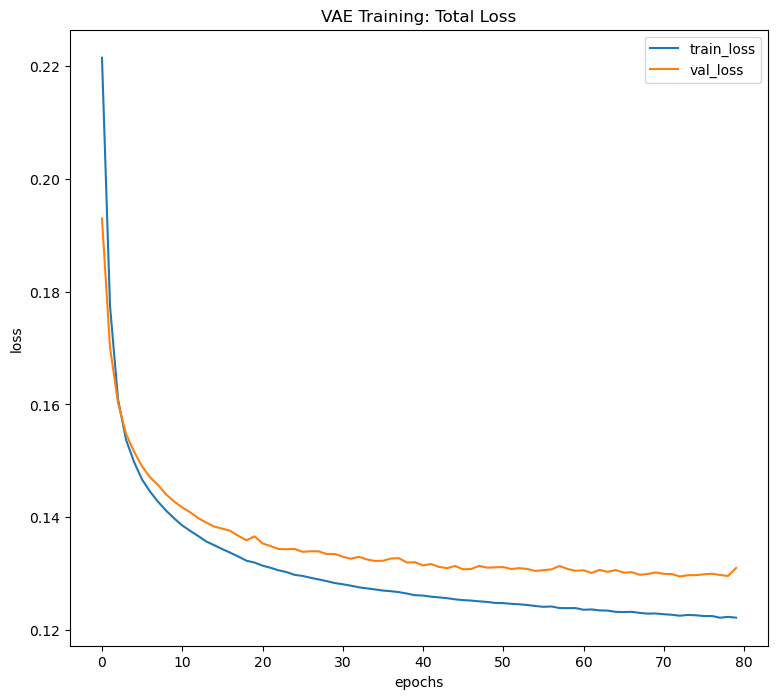

In [59]:
plt.figure(figsize = (9, 8))
plt.plot([train_history[e]['train_loss'] for e in train_history.keys()], label = 'train_loss')
plt.plot([train_history[e]['val_loss'] for e in train_history.keys()], label = 'val_loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("VAE Training: Total Loss")
plt.show()

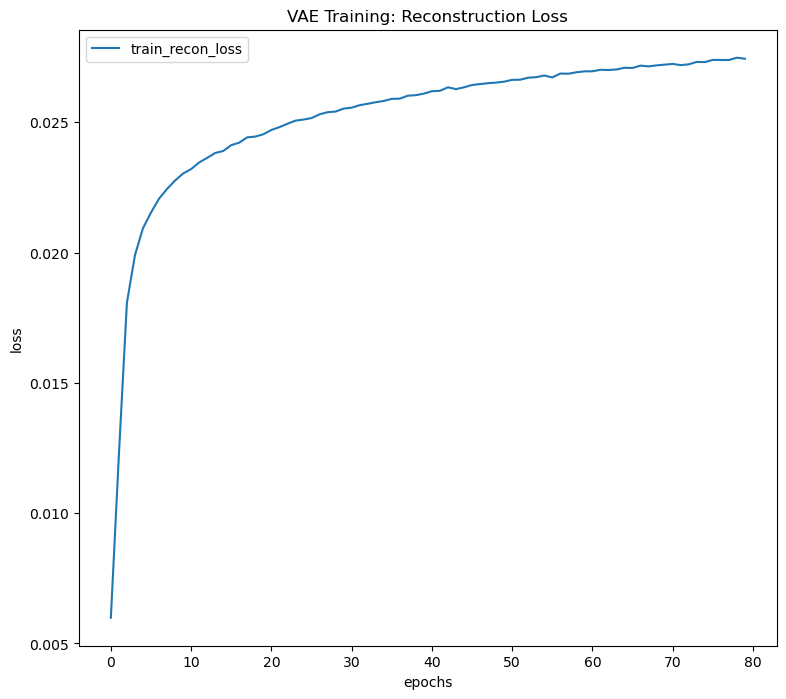

In [60]:
plt.figure(figsize = (9, 8))
plt.plot([train_history[e]['train_recon_loss'] for e in train_history.keys()], label = 'train_recon_loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("VAE Training: Reconstruction Loss")
plt.show()

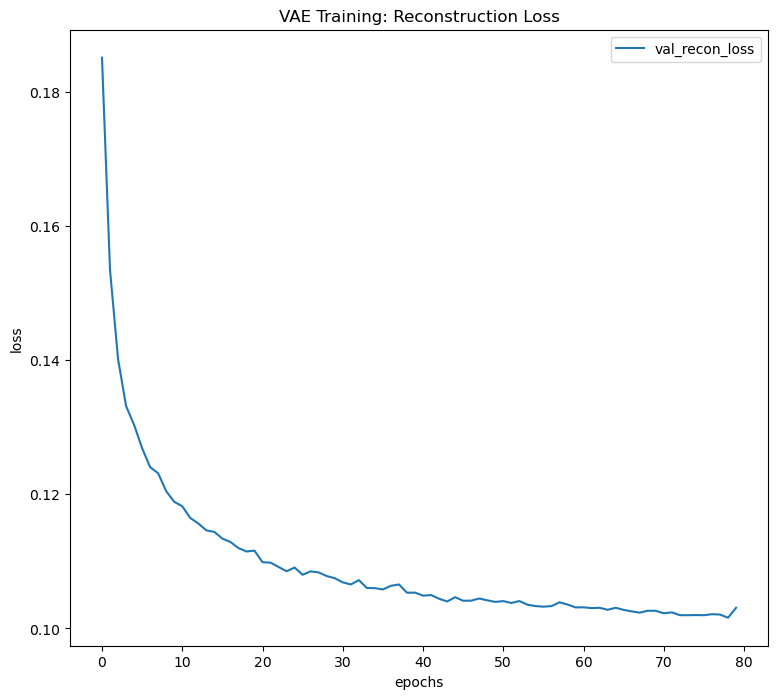

In [61]:
plt.figure(figsize = (9, 8))
plt.plot([train_history[e]['val_recon_loss'] for e in train_history.keys()], label = 'val_recon_loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("VAE Training: Reconstruction Loss")
plt.show()

_Reconstruction loss_ has 2 plots since training and validation losses are on different scales.

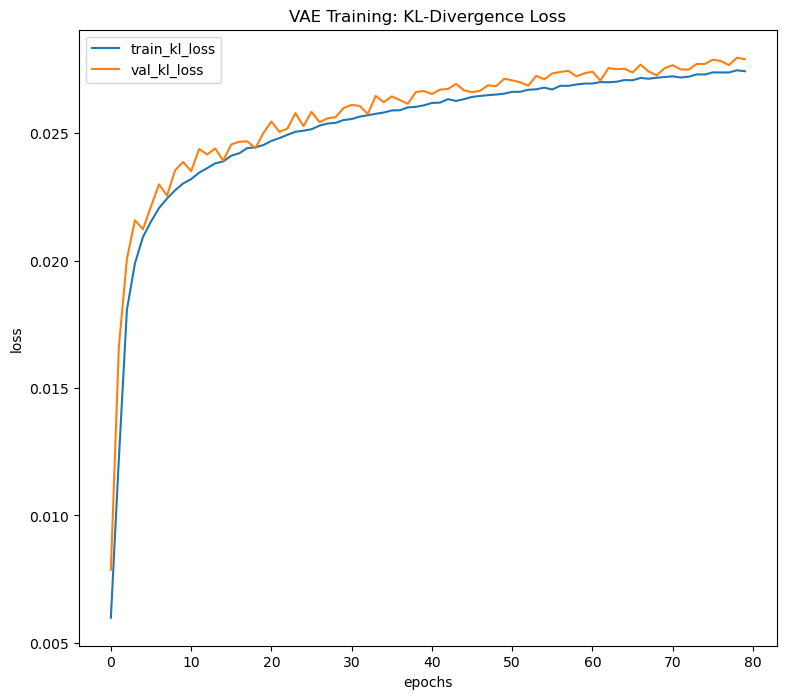

In [62]:
plt.figure(figsize = (9, 8))
plt.plot([train_history[e]['train_kl_loss'] for e in train_history.keys()], label = 'train_kl_loss')
plt.plot([train_history[e]['val_kl_loss'] for e in train_history.keys()], label = 'val_kl_loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("VAE Training: KL-Divergence Loss")
plt.show()

In [67]:
del model

In [105]:
# Load trained weights from before-
loaded_model = VAE_Dense(latent_space = 3).to(device)
loaded_model.load_state_dict(torch.load("VAE_LeNet300_MNIST_best_model.pth", map_location = torch.device('cpu')))

<All keys matched successfully>

In [ ]:
# Define gradient descent optimizer-
# optimizer = torch.optim.Adam(loaded_model.parameters(), lr = learning_rate)

In [139]:
# Python3 list for reconstructed images-
recon_images = []
orig_images = []
mu_embeddings = []
logvar_embeddings = []

In [140]:
for images in train_loader:
    images = images.to(device)
    recon_imgs, mu, logvar = loaded_model(images)
    recon_images.append(recon_imgs.cpu().detach().numpy())
    orig_images.append(images.cpu().detach().numpy())
    mu_embeddings.append(mu.cpu().detach().numpy())
    logvar_embeddings.append(logvar.cpu().detach().numpy())

In [141]:
del images, mu, logvar

In [142]:
recon_images = np.vstack(recon_images)
orig_images = np.vstack(orig_images)
mu_embeddings = np.vstack(mu_embeddings)
logvar_embeddings = np.vstack(logvar_embeddings)

In [143]:
recon_images.shape, orig_images.shape, mu_embeddings.shape, logvar_embeddings.shape

((60000, 784), (60000, 784), (60000, 3), (60000, 3))

In [144]:
recon_images = recon_images.reshape(-1, 28, 28)
orig_images = orig_images.reshape(-1, 28, 28)

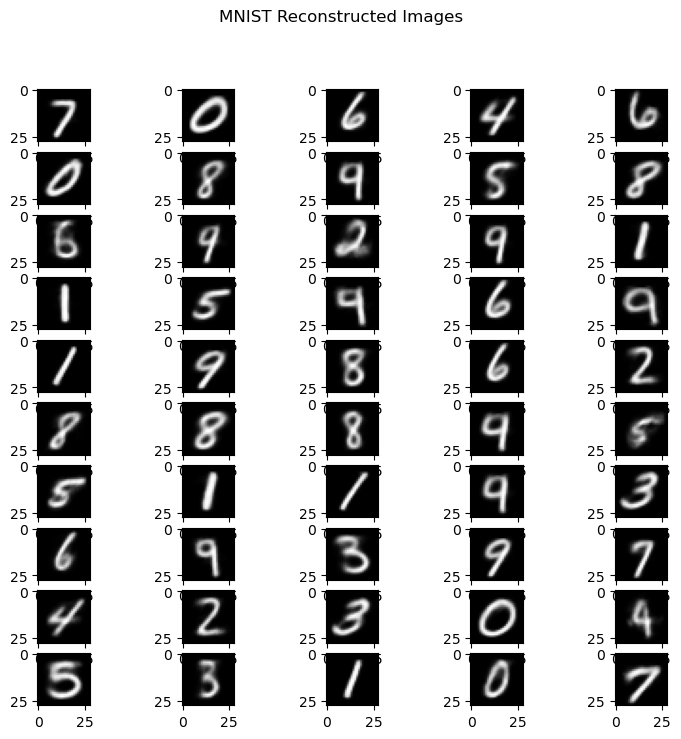

In [145]:
# Visualize reconstructed MNIST images-
plt.figure(figsize = (9, 8))
for i in range(50):
    # 10 rows and 5 columns-
    plt.subplot(10, 5, i + 1)
    plt.imshow(recon_images[i], cmap = 'gray')

plt.suptitle("MNIST Reconstructed Images")
plt.show()

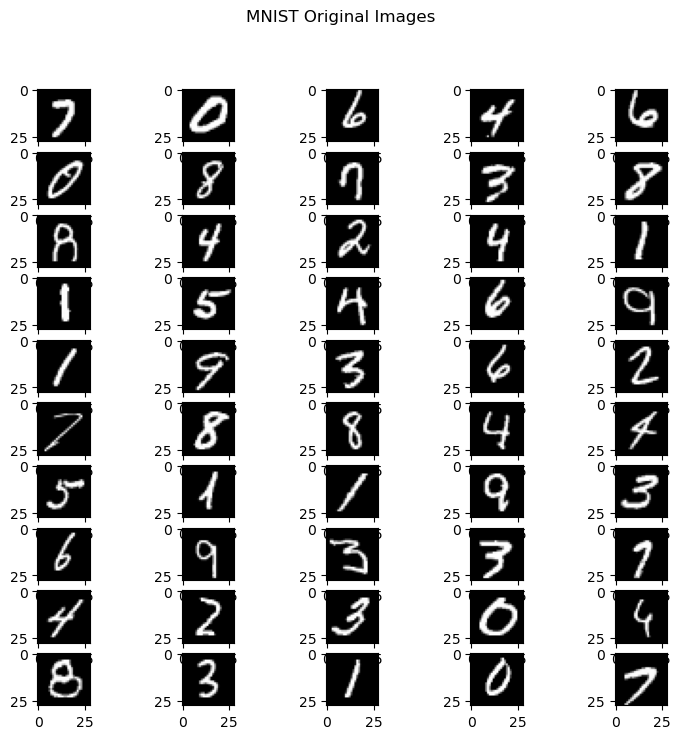

In [146]:
# Visualize reconstructed MNIST images-
plt.figure(figsize = (9, 8))
for i in range(50):
    # 10 rows and 5 columns-
    plt.subplot(10, 5, i + 1)
    plt.imshow(orig_images[i], cmap = 'gray')

plt.suptitle("MNIST Original Images")
plt.show()

In [147]:
orig_images.shape, recon_images.shape

((60000, 28, 28), (60000, 28, 28))

#### PSNR

$PSNR = 10 \times log_{10}\frac{R^2}{MSE}$

When using autoencoder or VAE, the probability of MSE = 0 is almost 0. So explicitly checking MSE = 0 might be redundant.

In [176]:
def compute_mse(orig, recon):
    mse = []
    for i in range(len(orig)):
        mse.append(np.mean(np.square(orig[i] - recon[i])))

    return np.array(mse)


In [216]:
def compute_psnr(orig, mse):
    psnr = 10 * np.log10(np.square(np.max(a = orig_images, axis = (1, 2))) / mse)
    return psnr


In [217]:
mse = compute_mse(orig = orig_images, recon = recon_images)

In [218]:
psnr = compute_psnr(orig = orig_images, mse = mse)

In [219]:
mse.shape, psnr.shape

((60000,), (60000,))

In [220]:
np.where(mse == 0.0)

(array([], dtype=int64),)

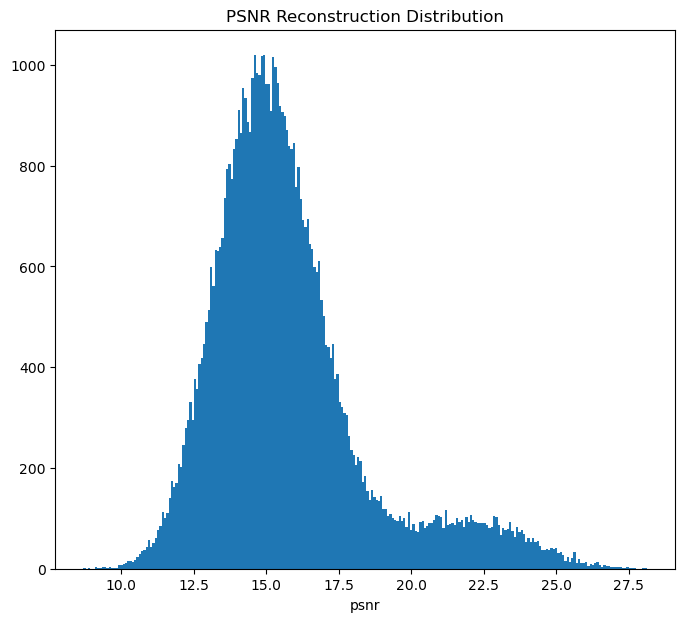

In [221]:
plt.figure(figsize = (8, 7))
n, b, _ = plt.hist(psnr, bins = int(np.ceil(np.sqrt(psnr.size))))
plt.xlabel("psnr")
plt.title("PSNR Reconstruction Distribution")
plt.show()

In [222]:
psnr.max(), psnr.min()

(28.123426, 8.689322)

In [230]:
np.sort(psnr)[-20:]

array([27.094566, 27.10636 , 27.111893, 27.14181 , 27.176628, 27.208881,
       27.21598 , 27.243938, 27.320139, 27.396109, 27.406315, 27.418768,
       27.453274, 27.468483, 27.506   , 27.509806, 27.616194, 27.68784 ,
       27.995451, 28.123426], dtype=float32)

In [234]:
np.where(psnr == psnr.max()), np.where(psnr == psnr.min()) 

((array([11442]),), (array([36498]),))

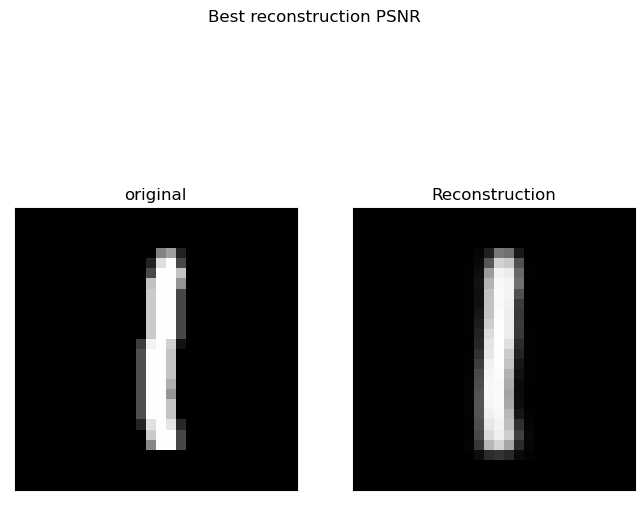

In [237]:
plt.figure(figsize = (8, 7))

# row 1, col 2 index 1-
plt.subplot(1, 2, 1)
plt.imshow(orig_images[11442], cmap = 'gray')
plt.title("original")
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis ')

# get current axes-
ax = plt.gca()
# hide x-axis-
ax.get_xaxis().set_visible(False)
# hide y-axis-
ax.get_yaxis().set_visible(False)


# index 2-
plt.subplot(1, 2, 2)
plt.imshow(recon_images[11442], cmap = 'gray')
plt.title("Reconstruction")
# plt.xlabel('X-axis ')
# plt.ylabel('Y-axis ')

# get current axes-
ax = plt.gca()
# hide x-axis-
ax.get_xaxis().set_visible(False)
# hide y-axis-
ax.get_yaxis().set_visible(False)

plt.suptitle("Best reconstruction PSNR")
plt.show()

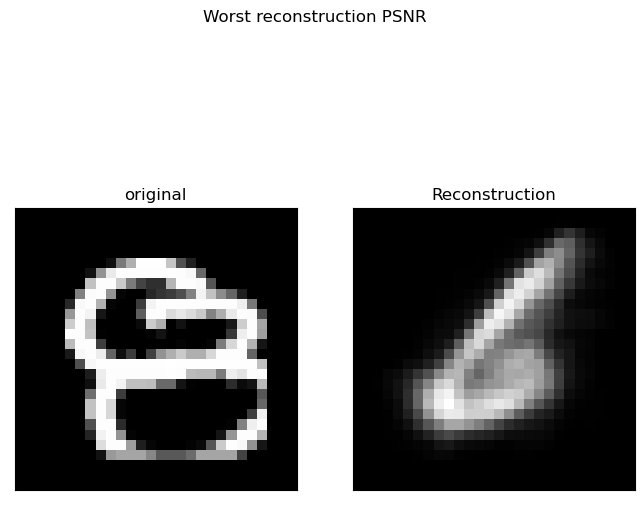

In [238]:
plt.figure(figsize = (8, 7))

# row 1, col 2 index 1-
plt.subplot(1, 2, 1)
plt.imshow(orig_images[36498], cmap = 'gray')
plt.title("original")
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis ')

# get current axes-
ax = plt.gca()
# hide x-axis-
ax.get_xaxis().set_visible(False)
# hide y-axis-
ax.get_yaxis().set_visible(False)


# index 2-
plt.subplot(1, 2, 2)
plt.imshow(recon_images[36498], cmap = 'gray')
plt.title("Reconstruction")
# plt.xlabel('X-axis ')
# plt.ylabel('Y-axis ')

# get current axes-
ax = plt.gca()
# hide x-axis-
ax.get_xaxis().set_visible(False)
# hide y-axis-
ax.get_yaxis().set_visible(False)

plt.suptitle("Worst reconstruction PSNR")
plt.show()

### Reconstruct/Generate images using _trained_ VAE model

In [114]:
def synthesize_mnist_images(model, num_samples = 256, latent_dim = 3):
    # Create new MNIST samples using trained model.
    
    # Sample from a multivariate, standard normal distribution-
    z = torch.randn(num_samples, latent_dim).to(device)

    reconstructions = torch.sigmoid(model.decoder(z)).cpu().detach().numpy()
    reconstructions = reconstructions.reshape(-1, 1, 28, 28)
    reconstructions = np.transpose(reconstructions, (0, 2, 3, 1))
    
    return reconstructions


In [115]:
reconstructions = synthesize_mnist_images(
    model = loaded_model, num_samples = 256,
    latent_dim = 3
)

In [116]:
reconstructions.shape

(256, 28, 28, 1)

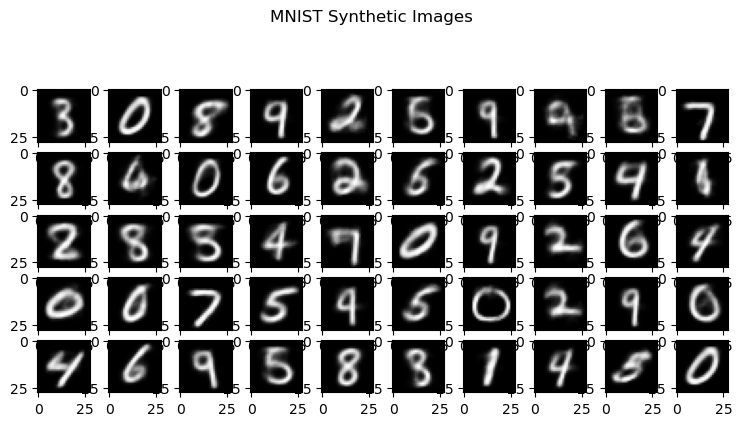

In [117]:
# Visualize 100 synthetic MNIST images-
plt.figure(figsize = (9, 8))
for i in range(50):
    # 10 rows and 10 columns-
    plt.subplot(10, 10, i + 1)
    plt.imshow(reconstructions[i], cmap = 'gray')

plt.suptitle("MNIST Synthetic Images")
plt.show()

In [118]:
del reconstructions

### Visualize _mean_ and _log-varinace_ in latent-space

In [ ]:
# Visualize latent space for 'mu' vector-
fig = px.scatter_3d(
    x = mu_embeddings[:, 0], y = mu_embeddings[:, 1],
    z = mu_embeddings[:, 2],
    # color = y_train,
    width = 800, height = 700
    )
fig.show()

In [ ]:
# Visualize latent space for 'log variance' vector-
fig = px.scatter_3d(
    x = logvar_embeddings[:, 0], y = logvar_embeddings[:, 1],
    z = logvar_embeddings[:, 2],
    # color = y_train,
    width = 800, height = 800
    )
fig.show()

In [126]:
print(f"Mean vector (mu): mean = {mu_embeddings.mean():4f} & std dev = {mu_embeddings.std():.4f}")

Mean vector (mu): mean = -0.000656 & std dev = 0.9955


In [127]:
print(f"log-variance (log-var): mean = {logvar_embeddings.mean():.4f} & std dev = {logvar_embeddings.std():.4f}")

log-variance (log-var): mean = -4.6164 & std dev = 0.4599


In [128]:
np.sum(mu_embeddings, axis = 0)

array([ 239.63184 , -431.8761  ,   74.108864], dtype=float32)

In [129]:
np.sum(logvar_embeddings, axis = 0)

array([-291674.6 , -259857.61, -279417.9 ], dtype=float32)

In [130]:
print("mean vector statistics:")
for i in range(3):
    print(f"lv = {i + 1}: mean = {mu_embeddings[:, i].mean():.4f} & std dev ="
          f" {mu_embeddings[:, i].std():.4f}"
         )

mean vector statistics:
lv = 1: mean = 0.0040 & std dev = 1.0225
lv = 2: mean = -0.0072 & std dev = 0.9913
lv = 3: mean = 0.0012 & std dev = 0.9722


In [131]:
print("log-variance vector statistics:")
for i in range(3):
    print(f"lv = {i + 1}: mean = {logvar_embeddings[:, i].mean():.4f} & std dev ="
          f" {logvar_embeddings[:, i].std():.4f}"
         )

log-variance vector statistics:
lv = 1: mean = -4.8613 & std dev = 0.3990
lv = 2: mean = -4.3310 & std dev = 0.3435
lv = 3: mean = -4.6570 & std dev = 0.4628


__Observation:__ All of the 3 latent variables are learning some useful information in the latent space.

#### Manually synthetize MNIST images by creating latent points

In [132]:
random_point = torch.tensor(
    [
        [0.0, 0.0, 0.0],
        [0.1, 0.5, -0.9],
        [-0.9, 0.2, 1.2],
        [2.5, 1.0, -2.5],
        [-0.3, 0.3, -0.3]
    ]
).to(device)

In [133]:
random_point.shape

torch.Size([5, 3])

In [134]:
# Get synthetic image-
recon_manual_points = torch.sigmoid(loaded_model.decoder(random_point)).cpu().detach().numpy()

In [135]:
recon_manual_points = recon_manual_points.reshape(-1, 1, 28, 28)
recon_manual_points = np.transpose(recon_manual_points, (0, 2, 3, 1))

In [136]:
recon_manual_points.shape

(5, 28, 28, 1)

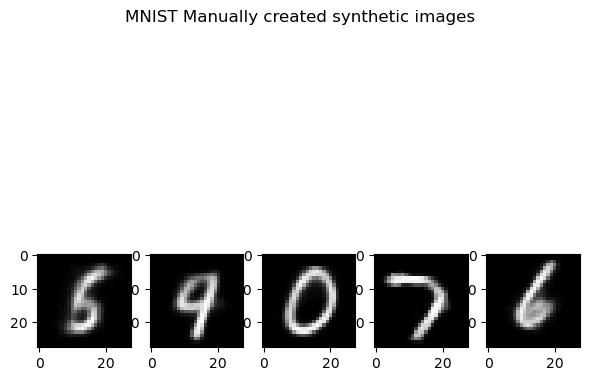

In [137]:
# Visualize 5 manually created synthetic MNIST images-
plt.figure(figsize = (7, 6))
for i in range(5):
    # 1 row and 5 columns-
    plt.subplot(1, 5, i + 1)
    plt.imshow(recon_manual_points[i], cmap = 'gray')

plt.suptitle("MNIST Manually created synthetic images")
plt.show()

In [138]:
del random_point, recon_manual_points

In [ ]:
# Save _encoded_ representation for training data-
'''
with open('MNIST_LeNet300_z.npy', 'wb') as file:
    np.save(file, z)
'''

In [ ]:
"""
with open('MNIST_LeNet300_z.npy', 'rb') as file:
    z_encoded = np.load(file)
"""